Plotting the embedded data...


C:\Users\SAYEMA\Anaconda3_2\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


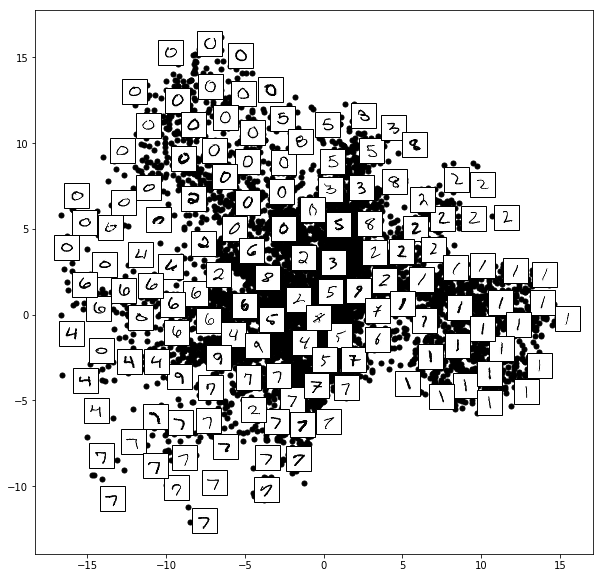

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import pickle
from numpy import genfromtxt
import numpy as np
from PIL import Image
import glob
import re
from struct import *
from skimage.transform import resize

path_dataset = 'C:/Users/SAYEMA/PycharmProjects/ECE657/FCBF/input/mnist/'
path_dataset_save = './input/pickle_dataset/MNIST/'
load_dataset_again = False

def read_MNIST_dataset(dataset = "training", path = "."):
    # https://gist.github.com/akesling/5358964
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        print('error.....')
    #Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)
    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)
    get_img = lambda idx: (lbl[idx], img[idx])
    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

def show_mnist_data(image):
    # https://gist.github.com/akesling/5358964
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

###### ----------- Read Facial dataset:

def read_image_dataset(dataset_path, imagesType='.png'):
    image_list, image_shape = read_images(folder_path=dataset_path, imagesType=imagesType)
    number_of_images = len(image_list)
    number_of_samples_of_each_class = 10
    X = []; y = []
    for image_index in range(number_of_images):
        class_index = int(image_index / number_of_samples_of_each_class)
        image = image_list[image_index]
        X.append(image)
        y.append(class_index)
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y, image_shape

def read_images(folder_path='./', imagesType='.png'):
    image_list = []
    images_address = folder_path + '*' + imagesType
    for filename in natsort(list_=glob.glob(images_address)):
        im = Image.open(filename)    # similar to: im = plt.imread(filename)
        image_shape = np.asarray(im).shape
        im = np.asarray(im).ravel()
        image_list.append(im)
    return image_list, image_shape

def natsort(list_):
    """ for sorting names of files in human-sense """
    # http://code.activestate.com/recipes/285264-natural-string-sorting/  ---> comment of r8qyfhp02
    # decorate
    tmp = [ (int(re.search('\d+', i).group(0)), i) for i in list_ ]
    tmp.sort()
    # undecorate
    return [ i[1] for i in tmp ]

###### ----------- Save variables:

def save_variable(variable, name_of_variable, path_to_save='./'):
    # https://stackoverflow.com/questions/6568007/how-do-i-save-and-restore-multiple-variables-in-python
    if not os.path.exists(path_to_save):  # https://stackoverflow.com/questions/273192/how-can-i-create-a-directory-if-it-does-not-exist
        os.makedirs(path_to_save)
    file_address = path_to_save + name_of_variable + '.pckl'
    f = open(file_address, 'wb')
    pickle.dump(variable, f)
    f.close()

###### ----------- Plot images in embedded space:

def plot_components(X_projected, images=None, ax=None, image_scale=1.0, markersize=10, thumb_frac=0.05, cmap='gray'):
    # https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html
    ax = ax or plt.gca()
    ax.plot(X_projected[:, 0], X_projected[:, 1], '.k', markersize=markersize)
    # images = images[:, ::image_scale, ::image_scale]  # downsample the images
    # images = imresize(images, (images.shape[0], images.shape[1]*image_scale, images.shape[2]*image_scale))   # downsample the images
    images = resize(images, (images.shape[0], images.shape[1]*image_scale, images.shape[2]*image_scale), order=5, preserve_range=True)
    if images is not None:
        min_dist_2 = (thumb_frac * max(X_projected.max(0) - X_projected.min(0))) ** 2
        shown_images = np.array([2 * X_projected.max(0)])
        for i in range(X_projected.shape[0]):
            dist = np.sum((X_projected[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, X_projected[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      X_projected[i])
            ax.add_artist(imagebox)
    #plt.show()
    plt.savefig('AE_plot.png')

def main():
    MNIST_subset_cardinality_training = 700  # picking from first samples of 60,000 samples
    MNIST_subset_cardinality_testing = 500  # picking from first samples of 10,000 samples
    if load_dataset_again:

        #training_data = list(read_MNIST_dataset(dataset = "training", path = path_dataset))
        testing_data = list(read_MNIST_dataset(dataset = "testing", path = path_dataset))

        #number_of_training_samples = len(training_data)
        dimension_of_data = 28 * 28
        #X_train = np.empty((0, dimension_of_data))
        #y_train = np.empty((0, 1))
        #for sample_index in range(number_of_training_samples):
        #    if np.mod(sample_index, 1) == 0:
        #        print('sample ' + str(sample_index) + ' from ' + str(number_of_training_samples) + ' samples...')
        #    label, pixels = training_data[sample_index]
        #    pixels_reshaped = np.reshape(pixels, (1, 28*28))
        #    X_train = np.vstack([X_train, pixels_reshaped])
        #    y_train = np.vstack([y_train, label])
        #y_train = y_train.ravel()

        number_of_testing_samples = len(testing_data)
        dimension_of_data = 28 * 28
        X_test = np.empty((0, dimension_of_data))
        y_test = np.empty((0, 1))
        for sample_index in range(number_of_testing_samples):
            if np.mod(sample_index, 1) == 0:
                print('sample ' + str(sample_index) + ' from ' + str(number_of_testing_samples) + ' samples...')
            label, pixels = testing_data[sample_index]
            pixels_reshaped = np.reshape(pixels, (1, 28*28))
            X_test = np.vstack([X_test, pixels_reshaped])
            y_test = np.vstack([y_test, label])
        y_test = y_test.ravel()

        #save_variable(X_train, 'X_train', path_to_save=path_dataset_save)
        #save_variable(y_train, 'y_train', path_to_save=path_dataset_save)
        save_variable(X_test, 'X_test', path_to_save=path_dataset_save)
        save_variable(y_test, 'y_test', path_to_save=path_dataset_save)
        
    else:
        #file = open(path_dataset_save+'X_train.pckl','rb')
        #X_train = pickle.load(file); file.close()
        #file = open(path_dataset_save+'y_train.pckl','rb')
        #y_train = pickle.load(file); file.close()
        file = open(path_dataset_save+'X_test.pckl','rb')
        X_test = pickle.load(file); file.close()
        file = open(path_dataset_save+'y_test.pckl','rb')
        y_test = pickle.load(file); file.close()
        
    X = X_test
    y = y_test
    image_shape = (28, 28)

    X_projected = genfromtxt('./output/latent.csv', delimiter=',', usecols = (0, 1))
    #X_projected = pd.read_csv("./output/latent.csv", header=None)
    print('Plotting the embedded data...')
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_components(X_projected=X_projected, images=X.reshape((-1, image_shape[0], image_shape[1])), ax=ax, image_scale=0.6, markersize=10, thumb_frac=0.05, cmap='gray_r')

if __name__ == '__main__':
    main()